# Posture Recognition and Finger Sliding Workspace

## Useful Resources

 - [Batch and Epoch training metrics for transformers Trainer](https://stackoverflow.com/questions/78311534/batch-and-epoch-training-metrics-for-transformers-trainer)
 - [Huggingface Trainer(): K-Fold Cross Validation](https://stackoverflow.com/questions/75510487/huggingface-trainer-k-fold-cross-validation)
 - [Metrics for Training Set in Trainer](https://discuss.huggingface.co/t/metrics-for-training-set-in-trainer/2461)
 - [Huggingface: Datasets](https://huggingface.co/docs/datasets/v2.12.0/en/installation)
 - [Hugginface: Transformers - Trainer API](https://huggingface.co/docs/transformers/trainer)

## 0. Import Library

In [31]:
import torch
import transformers
import numpy as np
import einops
import os
import datasets
import seedir as sd
import glob
import albumentations as A

from datasets import Dataset

## 1. Create Dataset Object

### Posture Recognition (Image Classification)

In [ ]:
from datasets import Image

# 1) Load filepaths and labels (you already have this)
image_rgb_dir = r'D:\RESEARCH ASSISTANT\6. Depth Camera\CODE\Orbbec Gemini 2XL\REMOTE\DEVELOPMENT\notebook\DATA\20250402\image\rgb'

filepaths, labels = [], []
for class_name in os.listdir(image_rgb_dir):
    class_dir = os.path.join(image_rgb_dir, class_name)
    for npy_path in glob.glob(os.path.join(class_dir, '*.npy')):
        filepaths.append(npy_path)
        labels.append(class_name)

# 2) Create Hugging‑Face Dataset
arrays = [np.load(p) for p in filepaths]
pr_ds = Dataset.from_dict({
    "image": arrays,
    "label": labels
})

pr_ds = pr_ds.class_encode_column("label")

# 1) initial 80/20 split
split1 = pr_ds.train_test_split(test_size=0.2, shuffle=True, seed=42, stratify_by_column="label")
train_ds = split1["train"]        # 80%
temp_ds  = split1["test"]         # 20%

# 2) split that 20% into half validation, half test → 10/10
split2 = temp_ds.train_test_split(test_size=0.5, shuffle=True, seed=42, stratify_by_column="label")
val_ds  = split2["train"]         # 10%
test_ds = split2["test"]          # 10%

# 4) Build label2id / id2label
unique_labels = sorted(set(labels))
label2id = {lab: idx for idx, lab in enumerate(unique_labels)}
id2label = {idx: lab for lab, idx in label2id.items()}

### Finger Sliding Workspace (Video Classification)

In [32]:
video_rgb_dir = r'D:\RESEARCH ASSISTANT\6. Depth Camera\CODE\Orbbec Gemini 2XL\REMOTE\DEVELOPMENT\notebook\DATA\20250402\video\rgb'

filepaths, labels = [], []
for class_name in os.listdir(video_rgb_dir):
    class_dir = os.path.join(video_rgb_dir, class_name)
    for npy_path in glob.glob(os.path.join(class_dir, '*.npy')):
        filepaths.append(npy_path)
        labels.append(class_name)

arrays = [np.load(p) for p in filepaths]
sw_ds = Dataset.from_dict({
    "video": arrays,
    "label": labels
})

sw_ds = sw_ds.class_encode_column("label")

split1 = sw_ds.train_test_split(test_size=0.33, shuffle=True, seed=42, stratify_by_column="label")
train_ds = split1["train"]       
val_ds  = split1["test"]

unique_labels = sorted(set(labels))
label2id = {lab: idx for idx, lab in enumerate(unique_labels)}
id2label = {idx: lab for lab, idx in label2id.items()}

Casting to class labels:   0%|          | 0/15 [00:00<?, ? examples/s]

## 2. Load Model

### Image

In [ ]:
from transformers import ViTImageProcessor, ViTModel, ViTForImageClassification
from torchinfo import summary
import torch
import copy

pr_processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
pr_model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(unique_labels),
    id2label=id2label,
    label2id=label2id
)

print(pr_model.config)

# Create dummy input (batch_size=1, channels=3, height=224, width=224)
dummy_input = torch.randn(1, 3, 224, 224)

# Send model to the same device as input
pr_model_eval = copy.deepcopy(pr_model)
pr_model_eval.eval()

# Print model summary
summary(pr_model_eval, input_data=dummy_input, depth=3, col_names=["input_size", "output_size", "num_params"])

### Video

In [44]:
from transformers import VideoMAEForVideoClassification, AutoImageProcessor
import numpy as np
from torchinfo import summary
import torch

sw_processor = AutoImageProcessor.from_pretrained("MCG-NJU/videomae-base-short-ssv2")
sw_model = VideoMAEForVideoClassification.from_pretrained(
    "MCG-NJU/videomae-base-short-ssv2",
    num_labels=len(unique_labels),
    id2label=id2label,
    label2id=label2id, 
)

print(sw_model.config)

print(summary(sw_model,
        input_size=(1, 16, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params"],
        row_settings=["depth"],
        device='cpu'))

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base-short-ssv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VideoMAEConfig {
  "_attn_implementation_autoset": true,
  "architectures": [
    "VideoMAEForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.0,
  "decoder_hidden_size": 384,
  "decoder_intermediate_size": 1536,
  "decoder_num_attention_heads": 6,
  "decoder_num_hidden_layers": 4,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "Hand_Close",
    "1": "Hand_Open",
    "2": "Hook_Hand",
    "3": "Intrinsic_Plan",
    "4": "Straight_Fist"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Hand_Close": 0,
    "Hand_Open": 1,
    "Hook_Hand": 2,
    "Intrinsic_Plan": 3,
    "Straight_Fist": 4
  },
  "layer_norm_eps": 1e-12,
  "model_type": "videomae",
  "norm_pix_loss": true,
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_frames": 16,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3",
  "tub

## 3. Apply Augmentation

### Image

**Set up Transformation Pipeline with Albumentations**

In [ ]:
mean = pr_processor.image_mean
std = pr_processor.image_std
size = pr_processor.size
h, w = pr_processor.size["height"], pr_processor.size["width"]

train_transform = A.Compose([
    A.Resize(h, w),

    # pick exactly one of these (p=1 ensures one op always applied)
    A.OneOf([
        A.NoOp(),

        A.Affine(shear=25, p=1.0),        # ShearX/Y combined
        A.Affine(translate_percent={"x":0.2,"y":0}, p=1.0),  # TranslateX
        A.Affine(translate_percent={"x":0,"y":0.2}, p=1.0),  # TranslateY
        A.Rotate(limit=45, p=1.0),

        A.Sharpen(p=1.0),

        A.Posterize(num_bits=4, p=1.0),
        A.Solarize(threshold=128, p=1.0),
        A.Equalize(p=1.0),
    ], p=1.0),

    A.Normalize(mean=mean, std=std),
    A.ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(h, w),
    A.Normalize(mean=mean, std=std),
    A.ToTensorV2()
])

import random
import matplotlib.pyplot as plt

def show_grid_transformed(ds, transform, title):
    idxs = random.sample(range(len(ds)), k=min(9, len(ds)))
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))
    fig.suptitle(title, fontsize=16)

    for ax, idx in zip(axes.ravel(), idxs):
        item = ds[idx]
        img = np.array(item["image"]).astype(np.uint8)
        label = item["label"]

        # Apply the Albumentations transform
        transformed = transform(image=img)["image"]

        # If normalized, unnormalize for display
        if transformed.max() <= 2 and transformed.min() >= -2:  # rough check
            transformed = transformed.permute(1, 2, 0).numpy()
            transformed = transformed * std + mean
            transformed = np.clip(transformed, 0, 1)
        else:
            transformed = transformed.transpose(1, 2, 0)

        ax.imshow(transformed)
        ax.set_title(label)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Usage:
show_grid_transformed(train_ds, train_transform, "Transformed Train Samples")
show_grid_transformed(val_ds, val_transform,  "Transformed Val Samples")

**Apply the Transformation Pipeline to Dataset**

In [ ]:
def preprocess_train(batch):
    imgs = []
    for img in batch["image"]:
        arr = np.array(img, copy=False)
        if arr.dtype != np.uint8:
            arr = arr.astype(np.uint8)
        imgs.append(train_transform(image=arr)["image"])

    batch["pixel_values"] = imgs
    batch["labels"]       = batch["label"]  # already ints
    return batch

def preprocess_val(batch):
    imgs = []
    for img in batch["image"]:
        arr = np.array(img, copy=False)
        if arr.dtype != np.uint8:
            arr = arr.astype(np.uint8)
        imgs.append(val_transform(image=arr)["image"])

    batch["pixel_values"] = imgs
    batch["labels"]       = batch["label"]  # already ints
    return batch

# map & reassign train_ds
train_ds = train_ds.map(
    preprocess_train,
    batched=True,
    batch_size=8,
    remove_columns=["image", "label"]
)
train_ds.set_format(type="torch", columns=["pixel_values", "labels"])

# map & reassign val_ds
val_ds = val_ds.map(
    preprocess_val,
    batched=True,
    batch_size=8,
    remove_columns=["image", "label"]
)
val_ds.set_format(type="torch", columns=["pixel_values", "labels"])

# map & reassign test_ds
test_ds = test_ds.map(
    preprocess_val,
    batched=True,
    batch_size=8,
    remove_columns=["image", "label"]
)
test_ds.set_format(type="torch", columns=["pixel_values","labels"])

### Video

**Set up Transformation Pipeline**

In [34]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
from typing import Tuple
import torchvision.transforms.functional as tvf
import random

class RandomShortSideScale(nn.Module):
    """
    Randomly pick a short‐side target in [min_size, max_size] and scale accordingly.
    Input: (T, C, H, W)
    """
    def __init__(self, min_size: int, max_size: int, interpolation: str = "bilinear"):
        super().__init__()
        self.min_size     = min_size
        self.max_size     = max_size
        self.interpolation = interpolation

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (T, C, H, W)
        t, c, h, w = x.shape
        size = random.randint(self.min_size, self.max_size)
        if w < h:
            new_h = int(math.floor((h / w) * size))
            new_w = size
        else:
            new_h = size
            new_w = int(math.floor((w / h) * size))
        # F.interpolate treats first dim (T) as batch:
        return F.interpolate(x, size=(new_h, new_w), 
                             mode=self.interpolation, align_corners=False)

class Normalize(nn.Module):
    """
    Normalize a (T, C, H, W) tensor by per-channel mean/std,
    treating T as the batch dimension.
    """
    def __init__(self,
                 mean: Tuple[float, float, float],
                 std:  Tuple[float, float, float],
                 inplace: bool = False):
        super().__init__()
        self.mean    = mean
        self.std     = std
        self.inplace = inplace

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x is (T, C, H, W); tvf.normalize expects (N, C, H, W)
        return tvf.normalize(x, self.mean, self.std, self.inplace)

class UniformTemporalSubsample(nn.Module):
    """
    Uniformly subsample `num_samples` frames from a (T, C, H, W) tensor.
    """
    def __init__(self, num_samples: int):
        super().__init__()
        if num_samples <= 0:
            raise ValueError(f"num_samples must be > 0, got {num_samples}")
        self.num_samples = num_samples

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (T, C, H, W)
        if x.ndim != 4:
            return x
        t = x.shape[0]
        if t == 0:
            return x
        idx = torch.linspace(0, t - 1, self.num_samples, 
                             device=x.device).round().long()
        return x.index_select(dim=0, index=idx)


In [ ]:
mean = sw_processor.image_mean
std = sw_processor.image_std
num_frames_to_samples = sw_model.config.num_frames
height = sw_processor.size.get("shortest_edge", sw_processor.size.get("height"))
width = height
resize_to = (height, width)

from torchvision.transforms import Compose, Lambda, RandomCrop, RandomHorizontalFlip

train_transform = Compose([
    UniformTemporalSubsample(num_frames_to_samples),      # → (T,C,H,W)
    RandomShortSideScale(256,320),                        # spatial scale on raw pixels
    RandomCrop(resize_to),                                # fixed 224×224 crop
    RandomHorizontalFlip(0.5),                            # augment
    Lambda(lambda x: x / 255.0),                          # now x is float [0,1]
    Normalize(mean, std),                                 # per‑channel norm
])

val_transform = Compose([
    UniformTemporalSubsample(num_frames_to_samples),            # → (T, C, H, W)
    Lambda(lambda x: x / 255.0),                                # to [0,1]
    Normalize(mean, std),                                       # per‑channel norm
    Lambda(lambda x: F.interpolate(                             
        x, size=resize_to, mode="bilinear", align_corners=False 
    )),                                                          # resize to (H,W) = resize_to
])

**Visualizaing Transformation Pipeline**

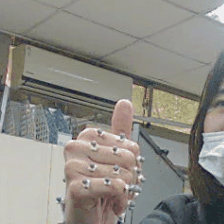

In [41]:
import imageio
from IPython.display import Image
import numpy as np

def unnormalize_img(img: np.ndarray) -> np.ndarray:
    # img is (H, W, C) in [0,1]
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)

def create_gif(video_tensor: torch.Tensor, filename="sample.gif") -> str:
    """
    video_tensor: (T, C, H, W)
    """
    T, C, H, W = video_tensor.shape
    frames = []
    for t in range(T):
        frame = video_tensor[t]                     # (C, H, W)
        arr = frame.permute(1, 2, 0).cpu().numpy()  # (H, W, C)
        arr = unnormalize_img(arr)
        frames.append(arr)
    imageio.mimsave(filename, frames, duration=0.25)
    return filename

def display_gif(video_tensor: torch.Tensor, gif_name="sample.gif") -> Image:
    """
    video_tensor: (T, C, H, W)
    """
    gif_path = create_gif(video_tensor, gif_name)
    return Image(filename=gif_path)

# -------------------------------------------------------
# Example usage on val_ds:

idx     = 0
example = val_ds[idx]

# extract & squeeze:
arr = np.array(example["video"], dtype=np.float32)
if arr.ndim == 5 and arr.shape[0] == 1:
    arr = arr.squeeze(0)         # now (T, C, H, W)

vid   = torch.from_numpy(arr).float()      # (T, C, H, W)
vid_t = train_transform(vid)                 # still (T, C, H, W)
display_gif(vid_t, gif_name="val_sample.gif")

**Apply the Transformation Pipeline to Dataset**

In [42]:
import torch

def preprocess_train(batch):
    pixel_values = []
    for arr in batch["video"]:
        # arr: numpy (T,C,H,W)
        vid  = torch.as_tensor(arr, dtype=torch.float32) 
        vid_t = train_transform(vid)               # now a (T,C,H,W) Tensor
        pixel_values.append(vid_t)
    batch["pixel_values"] = pixel_values
    batch["labels"]       =  batch["label"]
    return batch

def preprocess_val(batch):
    pixel_values = []
    for arr in batch["video"]:
        vid   = torch.as_tensor(arr, dtype=torch.float32) 
        vid_t = val_transform(vid)
        pixel_values.append(vid_t)
    batch["pixel_values"] = pixel_values
    batch["labels"]       = batch["label"]
    return batch

train_ds = train_ds.map(preprocess_train, batched=True, batch_size=8,
                        remove_columns=["video","label"])
train_ds.set_format(type="torch", columns=["pixel_values","labels"])

val_ds = val_ds.map(preprocess_val, batched=True, batch_size=8,
                    remove_columns=["video","label"])
val_ds.set_format(type="torch", columns=["pixel_values","labels"])


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

## 4. Fine-Tuning Model

### Image

**Setup `TrainingArguments`, `Trainer`, and `evaluate`**

In [ ]:
from transformers import Trainer, TrainerCallback, TrainingArguments
from transformers.modeling_outputs import SequenceClassifierOutput
import evaluate
from datetime import datetime
import pickle
import copy

model_ckpt = 'google/vit-base-patch16-224-in21k'
model_name = model_ckpt.split("/")[-1]
new_model_name = f"{model_name}-finetuned-pr240-stratify"
num_train_epochs = 50
EXPERIMENT_DATE = datetime.now().strftime("%Y%m%d")
SAVE_DIR = f"experiments/image/{EXPERIMENT_DATE}/{new_model_name}"
batch_size = 8

args_pr = TrainingArguments(
    output_dir=SAVE_DIR,
    remove_unused_columns=False, 
    eval_strategy="epoch",
    save_strategy="best",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

accuracy  = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall    = evaluate.load("recall")
f1        = evaluate.load("f1")
confusion = evaluate.load("confusion_matrix")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    # scalar metrics as before…
    acc   = accuracy.compute(predictions=preds, references=labels)["accuracy"]
    prec  = precision.compute(predictions=preds, references=labels, average="macro")["precision"]
    rec   = recall.compute(predictions=preds, references=labels, average="macro")["recall"]
    f1sc  = f1.compute(predictions=preds, references=labels, average="macro")["f1"]

    # get confusion matrix and turn it into a nested Python list
    cm = confusion.compute(predictions=preds, references=labels)["confusion_matrix"]
    cm_list = cm.tolist()

    return {
        "accuracy":          acc,
        "precision":         prec,
        "recall":            rec,
        "f1":                f1sc,
        "confusion_matrix":  cm_list,    # now JSON‑serializable
    }

class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # these will accumulate _all_ batches in the current epoch
        self.epoch_losses     = []
        self.epoch_preds      = []
        self.epoch_labels     = []

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """
        Overrides Trainer.compute_loss to store batch‐level loss & preds/labels.
        """
        labels = inputs.get("labels", None)
        outputs = model(**inputs)
        loss   = outputs.loss
        logits = outputs.logits

        if labels is not None:
            # 1) store the loss
            self.epoch_losses.append(loss.item())
            # 2) store predictions + labels as 1D arrays
            preds = logits.argmax(dim=-1).detach().cpu().numpy()
            labs  = labels.detach().cpu().numpy()
            self.epoch_preds .extend(preds.tolist())
            self.epoch_labels.extend(labs.tolist())

        return (loss, outputs) if return_outputs else loss

class MetricsCallback(TrainerCallback):
    def __init__(self, trainer):
        super().__init__()
        self.trainer = trainer

        # lists to hold epoch‐by‐epoch values
        self.train_losses     = []
        self.train_accuracies = []
        self.eval_losses      = []
        self.eval_accuracies  = []
        self.eval_confusion_matrices = [] 

    def on_epoch_end(self, args, state, control, **kwargs):
        # Compute average training loss & accuracy for the epoch
        t = self.trainer
        avg_loss = float(np.mean(t.epoch_losses))
        acc      = np.mean(
            np.array(t.epoch_preds) == np.array(t.epoch_labels)
        )

        # Store & clear for next epoch
        self.train_losses    .append(avg_loss)
        self.train_accuracies.append(acc)
        t.epoch_losses .clear()
        t.epoch_preds  .clear()
        t.epoch_labels .clear()

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        # metrics come prefixed with "eval_"
        self.eval_losses   .append(metrics["eval_loss"])
        self.eval_accuracies.append(metrics["eval_accuracy"])
        # record the confusion matrix
        self.eval_confusion_matrices.append(metrics["eval_confusion_matrix"])


trainer = CustomTrainer(
    model=copy.deepcopy(pr_model),                 
    args=args_pr,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=pr_processor,          
    compute_metrics=compute_metrics, 
)

metrics_cb = MetricsCallback(trainer)
trainer.add_callback(metrics_cb)

**Training**

In [ ]:
train_results = trainer.train()

**Testing History Saving**

In [ ]:
history_test_ds = trainer.evaluate(test_ds)
history_test_ds = {
    'eval_accuracy': history_test_ds['eval_accuracy'],
    'eval_preicision': history_test_ds['eval_precision'],
    'eval_recall': history_test_ds['eval_recall'],
    'eval_f1': history_test_ds['eval_f1'],
    'eval_confusion_matrix': history_test_ds['eval_confusion_matrix'],
}
history_test_ds_path = os.path.join(SAVE_DIR, "history_testing.pkl")
with open(history_test_ds_path, "wb") as f:
    pickle.dump(history_test_ds, f)

**Training, Validation History Saving**

In [ ]:
history_val_ds = {
    "train_loss":     metrics_cb.train_losses,
    "train_accuracy": metrics_cb.train_accuracies,
    "eval_loss":      metrics_cb.eval_losses,
    "eval_accuracy":  metrics_cb.eval_accuracies,
    "eval_confusion_matrix": metrics_cb.eval_confusion_matrices,
}
history_train_val_ds_path = os.path.join(SAVE_DIR, "history_trainval.pkl")
with open(history_train_val_ds_path, "wb") as f:
    pickle.dump(history_val_ds, f)

**Plotting**

In [ ]:
def visualize_train_val_losses(save_dir: str) -> None:
    import pickle
    import matplotlib.pyplot as plt
    import glob
    import os

    # Set global font properties
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.size'] = 15

    # Search for history pickle files
    history_files = glob.glob(os.path.join(save_dir, "*.pkl"))

    for history_path in history_files:
        filename = os.path.basename(history_path)

        if "trainval" not in filename:
            continue  # skip non-trainval files

        print(f"Visualizing: {filename}")
        with open(history_path, "rb") as f:
            hist = pickle.load(f)

        fig, axs = plt.subplots(2, 1, figsize=(15, 15))

        # Plot loss
        axs[0].plot(hist["train_loss"], label="Train Loss", color='red')
        axs[0].plot(hist["eval_loss"], label="Validation Loss", color='blue')
        axs[0].set_title('Posture Recognition Training Loss', fontweight='bold')
        axs[0].set_ylabel('Loss')
        axs[0].legend()

        # Plot accuracy
        axs[1].plot(hist["train_accuracy"], label="Train Accuracy", color='orange')
        axs[1].plot(hist["eval_accuracy"], label="Validation Accuracy", color='green')
        axs[1].set_title('Posture Recognition Training Accuracy', fontweight='bold')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Accuracy')
        axs[1].legend()

        plt.tight_layout()
        plt.show()

def visualize_confusion_matrix(save_dir: str, mode: str = "trainval") -> None:
    import pickle
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import ConfusionMatrixDisplay
    import glob
    import os

    # Look for the correct .pkl file based on mode
    history_files = glob.glob(os.path.join(save_dir, "*.pkl"))
    matched_file = None

    for file in history_files:
        if mode.lower() in os.path.basename(file).lower():
            matched_file = file
            break

    if not matched_file:
        print(f"[ERROR] No history file found in '{save_dir}' for mode '{mode}'")
        return

    print(f"[INFO] Loading confusion matrix from: {matched_file}")
    with open(matched_file, "rb") as f:
        hist = pickle.load(f)

    # Decide whether to use the last epoch or a single matrix
    if mode == "trainval":
        cm_data = hist["eval_confusion_matrix"][-1]
        title = "Confusion Matrix (Last Epoch - Train/Val)"
    else:
        cm_data = hist["eval_confusion_matrix"]
        title = f"Confusion Matrix ({mode.capitalize()})"

    cm = np.array(cm_data)
    class_names = [
        "Hand Open",
        "Hand Close",
        "Hook Hand",
        "Intrinsic Plus",
        "Straight Fist"
    ]

    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    ax.set_title(title, fontweight="bold")

    plt.tight_layout()
    plt.show()

visualize_train_val_losses(SAVE_DIR)
visualize_confusion_matrix(SAVE_DIR, mode="test")

### Video

**Setup `TrainingArguments`, `Trainer`, and `evaluate`**

In [46]:
from transformers import Trainer, TrainerCallback, TrainingArguments
import evaluate
from datetime import datetime
import pickle
import copy

model_ckpt = 'MCG-NJU/videomae-base-short-ssv2_without_random_flip'
model_name = model_ckpt.split("/")[-1]
new_model_name = f"{model_name}-finetuned-psw15"
num_train_epochs = 50
EXPERIMENT_DATE = datetime.now().strftime("%Y%m%d")
SAVE_DIR = f"experiments/video/{EXPERIMENT_DATE}/{new_model_name}"
batch_size = 8

args_pr = TrainingArguments(
    output_dir=SAVE_DIR,
    remove_unused_columns=False, 
    eval_strategy="epoch",
    save_strategy="best",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

accuracy  = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall    = evaluate.load("recall")
f1        = evaluate.load("f1")
confusion = evaluate.load("confusion_matrix")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    # scalar metrics as before…
    acc   = accuracy.compute(predictions=preds, references=labels)["accuracy"]
    prec  = precision.compute(predictions=preds, references=labels, average="macro")["precision"]
    rec   = recall.compute(predictions=preds, references=labels, average="macro")["recall"]
    f1sc  = f1.compute(predictions=preds, references=labels, average="macro")["f1"]

    # get confusion matrix and turn it into a nested Python list
    cm = confusion.compute(predictions=preds, references=labels)["confusion_matrix"]
    cm_list = cm.tolist()

    return {
        "accuracy":          acc,
        "precision":         prec,
        "recall":            rec,
        "f1":                f1sc,
        "confusion_matrix":  cm_list,    # now JSON‑serializable
    }

class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # these will accumulate _all_ batches in the current epoch
        self.epoch_losses     = []
        self.epoch_preds      = []
        self.epoch_labels     = []

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """
        Overrides Trainer.compute_loss to store batch‐level loss & preds/labels.
        """
        labels = inputs.get("labels", None)
        outputs = model(**inputs)
        loss   = outputs.loss
        logits = outputs.logits

        if labels is not None:
            # 1) store the loss
            self.epoch_losses.append(loss.item())
            # 2) store predictions + labels as 1D arrays
            preds = logits.argmax(dim=-1).detach().cpu().numpy()
            labs  = labels.detach().cpu().numpy()
            self.epoch_preds .extend(preds.tolist())
            self.epoch_labels.extend(labs.tolist())

        return (loss, outputs) if return_outputs else loss

class MetricsCallback(TrainerCallback):
    def __init__(self, trainer):
        super().__init__()
        self.trainer = trainer

        # lists to hold epoch‐by‐epoch values
        self.train_losses     = []
        self.train_accuracies = []
        self.eval_losses      = []
        self.eval_accuracies  = []
        self.eval_confusion_matrices = [] 

    def on_epoch_end(self, args, state, control, **kwargs):
        # Compute average training loss & accuracy for the epoch
        t = self.trainer
        avg_loss = float(np.mean(t.epoch_losses))
        acc      = np.mean(
            np.array(t.epoch_preds) == np.array(t.epoch_labels)
        )

        # Store & clear for next epoch
        self.train_losses    .append(avg_loss)
        self.train_accuracies.append(acc)
        t.epoch_losses .clear()
        t.epoch_preds  .clear()
        t.epoch_labels .clear()

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        # metrics come prefixed with "eval_"
        self.eval_losses   .append(metrics["eval_loss"])
        self.eval_accuracies.append(metrics["eval_accuracy"])
        self.eval_confusion_matrices.append(metrics["eval_confusion_matrix"])

trainer = CustomTrainer(
    model=copy.deepcopy(sw_model),                 
    args=args_pr,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=sw_processor,          
    compute_metrics=compute_metrics, 
)

metrics_cb = MetricsCallback(trainer)
trainer.add_callback(metrics_cb)

C:\Users\11208120\AppData\Local\Temp\ipykernel_28584\390046848.py:61: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


**Training**

In [ ]:
train_results = trainer.train()

**Training, Validation History Saving**

In [ ]:
history_val_ds = {
    "train_loss":     metrics_cb.train_losses,
    "train_accuracy": metrics_cb.train_accuracies,
    "eval_loss":      metrics_cb.eval_losses,
    "eval_accuracy":  metrics_cb.eval_accuracies,
    "eval_confusion_matrix": metrics_cb.eval_confusion_matrices,
}
history_train_val_ds_path = os.path.join(SAVE_DIR, "history_trainval.pkl")
with open(history_train_val_ds_path, "wb") as f:
    pickle.dump(history_val_ds, f)

**Plotting**

In [ ]:
def visualize_train_val_losses(save_dir: str) -> None:
    import pickle
    import matplotlib.pyplot as plt
    import glob
    import os

    # Set global font properties
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.size'] = 15

    # Search for history pickle files
    history_files = glob.glob(os.path.join(save_dir, "*.pkl"))

    for history_path in history_files:
        filename = os.path.basename(history_path)

        if "trainval" not in filename:
            continue  # skip non-trainval files

        print(f"Visualizing: {filename}")
        with open(history_path, "rb") as f:
            hist = pickle.load(f)

        fig, axs = plt.subplots(2, 1, figsize=(15, 15))

        # Plot loss
        axs[0].plot(hist["train_loss"], label="Train Loss", color='red')
        axs[0].plot(hist["eval_loss"], label="Validation Loss", color='blue')
        axs[0].set_title('Posture Recognition Training Loss', fontweight='bold')
        axs[0].set_ylabel('Loss')
        axs[0].legend()

        # Plot accuracy
        axs[1].plot(hist["train_accuracy"], label="Train Accuracy", color='orange')
        axs[1].plot(hist["eval_accuracy"], label="Validation Accuracy", color='green')
        axs[1].set_title('Posture Recognition Training Accuracy', fontweight='bold')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Accuracy')
        axs[1].legend()

        plt.tight_layout()
        plt.show()

def visualize_confusion_matrix(save_dir: str, mode: str = "trainval") -> None:
    import pickle
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import ConfusionMatrixDisplay
    import glob
    import os

    # Look for the correct .pkl file based on mode
    history_files = glob.glob(os.path.join(save_dir, "*.pkl"))
    matched_file = None

    for file in history_files:
        if mode.lower() in os.path.basename(file).lower():
            matched_file = file
            break

    if not matched_file:
        print(f"[ERROR] No history file found in '{save_dir}' for mode '{mode}'")
        return

    print(f"[INFO] Loading confusion matrix from: {matched_file}")
    with open(matched_file, "rb") as f:
        hist = pickle.load(f)

    # Decide whether to use the last epoch or a single matrix
    if mode == "trainval":
        cm_data = hist["eval_confusion_matrix"][-1]
        title = "Confusion Matrix (Last Epoch - Train/Val)"
    else:
        cm_data = hist["eval_confusion_matrix"]
        title = f"Confusion Matrix ({mode.capitalize()})"

    cm = np.array(cm_data)
    class_names = [
        "Hand Open",
        "Hand Close",
        "Hook Hand",
        "Intrinsic Plus",
        "Straight Fist"
    ]

    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    ax.set_title(title, fontweight="bold")

    plt.tight_layout()
    plt.show()

visualize_train_val_losses(SAVE_DIR)
visualize_confusion_matrix(SAVE_DIR, mode="trainval")

## 5. Inferring

### Image

**Inference**

In [ ]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.functional import softmax
from transformers import ViTForImageClassification, ViTImageProcessor

# Load model and processor
ckpt_dir = r'D:\RESEARCH ASSISTANT\6. Depth Camera\CODE\Orbbec Gemini 2XL\REMOTE\DEVELOPMENT\notebook\experiments\image\20250419\vit-base-patch16-224-in21k-finetuned-pr240\checkpoint-96'
model = ViTForImageClassification.from_pretrained(ckpt_dir)
processor = ViTImageProcessor.from_pretrained(ckpt_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

# Prepare mean/std for un-normalization
mean = torch.tensor(processor.image_mean).view(1, 3, 1, 1).to(device)
std = torch.tensor(processor.image_std).view(1, 3, 1, 1).to(device)

# Sample 9 examples from test_ds
idxs = random.sample(range(len(test_ds)), k=min(9, len(test_ds)))

fig, axes = plt.subplots(3, 3, figsize=(9, 9))
for ax, idx in zip(axes.ravel(), idxs):
    item = test_ds[idx]
    pixel_values = item["pixel_values"]  # Tensor [3, H, W]
    label_idx = item["labels"].item()      
    true_label = id2label[label_idx]

    # Run inference
    input_tensor = pixel_values.unsqueeze(0).to(device)  # [1, 3, H, W]
    with torch.no_grad():
        outputs = model(pixel_values=input_tensor)
        probs = softmax(outputs.logits, dim=-1)
        pred_idx    = probs.argmax(dim=-1).item()
        pred_label  = id2label[pred_idx]
        confidence = probs[0, pred_idx].item()

    # Un-normalize for display
    img_tensor = input_tensor * std + mean
    img = img_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
    img = np.clip(img, 0, 1)

    ax.imshow(img)
    color = "green" if pred_label == true_label else "red"
    ax.set_title(f"{pred_label} ({confidence:.2f})", color=color)
    ax.axis("off")

plt.tight_layout()
plt.show()